In [7]:
from src.configuration import conf
import tables
import matplotlib.pyplot as plt
import os
import numpy as np

# Basic Data Extraction
Each variable is a time series accross a single game run.

Unintuitve Variables Encodings:
* player_x_target_states:
  * Before comma: Index of current target ant
  * After comma: conquest progress
  * Negative value if there is no current target

* player_x_score_states:
  * Encodes the score popup animation
  * Before comma: Score to show
  * After comma: animation progress
  * Nan if there the popup animation is not shown
   

In [14]:
# Print game course data sets
output_dir_path = os.path.abspath('') + '/' + conf.output_folder_name
#records_folder = os.listdir(output_dir_path + '/' + 'gs_24-08-21_15-01-40.h5')
records_folder = os.listdir(output_dir_path + '/')
#print(records_folder)
records = []
#print(records_folder)

#print(os.listdir(output_dir_path))
#print(os.path.isdir(output_dir_path))
#print(os.listdir(output_dir_path + '/' + 'records_0'))

for name in records_folder:
    path = output_dir_path + '/' + name
    if os.path.isdir(path):
        for file in os.listdir(path):
            #print(name + '/' + file)
            records.append(name + '/' + file)
    else:
        records.append(name)
records

['records_0/gs_all_dynamics.h5',
 'records_0/gs_p0_follows_p1.h5',
 'records_1/gs_wasd_competitive_0.h5',
 'records_1/gs_wasd_competitive_1.h5',
 'records_1/gs_wasd_p0_follows_p1_0.h5',
 'records_1/gs_wasd_p0_follows_p1_1.h5',
 'records_1/gs_wasd_p1_follows_p0_0.h5',
 'records_1/gs_wasd_p1_follows_p0_1.h5',
 'records_2/gs_competitive_1.h5',
 'records_2/gs_p1_follows_p0_0.h5',
 'records_2/gs_p1_follows_p0_1.h5',
 'records_2/gs_p0_follows_p1_0.h5',
 'records_2/gs_p0_follows_p1_1.h5',
 'records_2/gs_competitive_0.h5',
 'gs_20-06-21_12-47-19.h5',
 'gs_29-06-21_14-47-58.h5',
 'gs_29-06-21_19-20-42.h5',
 'gs_29-06-21_20-16-57.h5',
 'gs_29-06-21_20-30-15.h5',
 'gs_29-06-21_20-44-18.h5',
 'gs_29-06-21_20-45-20.h5',
 'gs_12-07-21_08-35-14.h5',
 'gs_24-08-21_15-01-40.h5',
 'gs_24-08-21_15-02-42.h5',
 'gs_24-08-21_15-03-44.h5',
 'gs_24-08-21_15-06-35.h5',
 'gs_25-08-21_11-42-36.h5',
 'gs_25-08-21_11-43-38.h5',
 'gs_25-08-21_12-22-01.h5',
 'gs_25-08-21_12-22-38.h5',
 'gs_25-08-21_12-24-06.h5',
 'g

In [11]:
records

[]

In [107]:
def file_to_data_dict(file):
    data = file.root.data
        
    general_data = data[:, 0]
    player_data  = data[:,1:3]
    score_data   = data[:, 3]
    ant_data     = data[:,4:]
    
    identifier = str(int(general_data[0, 3])).zfill(3)
    lap = -1
    p0_idx = -1
    p1_idx = -1
    if len(identifier) == 3:
        lap = int(identifier[0])
        p0_idx = int(identifier[1])
        p1_idx = int(identifier[2])
    
    return {
        
        'player_0_scale_factors' : general_data[:, 0],
        'player_1_scale_factors' : general_data[:, 1],
        'timestamps'             : general_data[:, 2],
        
        'player_0_positions' : player_data[:, 0,: 2],
        'player_1_positions' : player_data[:, 1,: 2],

        'player_0_target_states' : player_data[:, 0, 2],
        'player_1_target_states' : player_data[:, 1, 2],
        
        'player_0_pings' : player_data[:, 0, 3],
        'player_1_pings' : player_data[:, 1, 3],

        'player_0_scores' : score_data[:, 0],
        'player_1_scores' : score_data[:, 1],
        
        'player_0_score_state' : score_data[:, 2],
        'player_1_score_state' : score_data[:, 3],

        'ant_x_positions' : ant_data[:,:, 0],
        'ant_y_positions' : ant_data[:,:, 1],
        'ant_kinds'       : ant_data[:,:, 2],
        
        'lap'    : lap,
        'p0_idx' : p0_idx,
        'p1_idx' : p1_idx,
    }

def path_to_data_dict(path):
    output_dir_path = os.path.abspath('') + '/' + conf.output_folder_name
    file = tables.open_file(output_dir_path + path, mode='r')
    return file_to_data_dict(file)
   

path = output_dir_path + '/' + records[-2]
file = tables.open_file(path, mode='r')
game_data = file_to_data_dict(file)
print(path)

/home/brain/uni/pract/dyadic_task/game_records/gs_02-09-21_18-56-37/203.h5


In [113]:
def get_game_data_dicts_for_folder(folder_name):
    output_dir_path = os.path.abspath('') + '/' + conf.output_folder_name + '/' + folder_name
    file_names = os.listdir(output_dir_path)
    table_files = [tables.open_file(output_dir_path + '/' + name, mode='r') for name in file_names]
    return [file_to_data_dict(file) for file in table_files]

retreat_record = get_game_data_dicts_for_folder('gs_02-09-21_18-56-37')

In [52]:
def check_reliability_in_time(timestamps):
    recording_duration = timestamps[-1] - timestamps[0]
    diff = np.zeros(len(timestamps)-1)
    for i in range(len(timestamps)-1):
        diff[i] = timestamps[i+1] - timestamps[i]
    print(f'Actual Value: {recording_duration}')
    print(f'Target Value: {conf.lap_time}')
    print(f'Difference in time mean actual Value: {diff.mean()}')
    print(f'Difference in time mean target Value: {1 / conf.pos_updates_ps}')
    print(f'Difference in time standard derivation: {diff.std()}')
    
    #Actual - Target Value history
    #.89
    #.77 preproduce game_states
    #.45 use exponential moving average improve time scheduling
    #.38 the same as above but no ping requests and no player movement
    #-.02 rewrote server and introduced new game scheduler with own thread,
    # no moving averages or preprocessing requiered!

check_reliability_in_time(game_data['timestamps'])

Actual Value: 299.9781234264374
Target Value: 300
Difference in time mean actual Value: 0.016666377211313817
Difference in time mean target Value: 0.016666666666666666
Difference in time standard derivation: 6.91393922078513e-05


In [35]:
def print_client_field_sizes(game_data):
    print('Initial client field sizes:')
    sf = [game_data['player_0_scale_factors'][0], game_data['player_1_scale_factors'][0]]
    field_server_width, field_server_height = conf.field_size
    print(f'player 1: {int(field_server_width * sf[0])} {int(field_server_height * sf[0])}')
    print(f'player 2: {int(field_server_width * sf[1])} {int(field_server_height * sf[1])}')
    
print_client_field_sizes(game_data)

Initial client field sizes:
player 1: 2307 1368
player 2: 1184 702


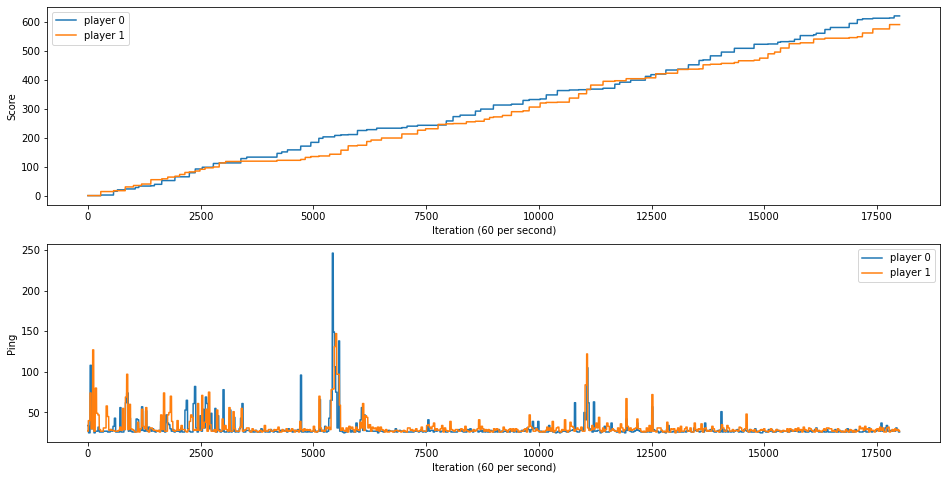

In [54]:
def plot_ping_and_score(game_data):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=((16,8)))
    ax1.set_xlabel(f'Iteration ({conf.pos_updates_ps} per second)')
    ax1.set_ylabel('Score')
    ax1.plot(game_data['player_0_scores'], label='player 0')
    ax1.plot(game_data['player_1_scores'], label='player 1')
    ax1.legend()
    ax2.set_xlabel(f'Iteration ({conf.pos_updates_ps} per second)')
    ax2.set_ylabel('Ping')
    ax2.plot(game_data['player_0_pings'], label='player 0')
    ax2.plot(game_data['player_1_pings'], label='player 1')
    ax2.legend()
    
plot_ping_and_score(game_data)

In [24]:
def vec_ncc(arg_a, arg_b, shift=0):  # a and b should have same length
    a, b = None, None
    if shift >= 0:
        a = arg_a[:len(arg_a)-shift]
        b = arg_b[shift:len(arg_a)]
    else:
        a = arg_a[-1*shift:len(arg_a)]
        b = arg_b[:len(arg_a)+shift]
    a_mean, b_mean = a.mean(0), b.mean(0)
    try:
        normalization_factor = 1/len(a)/(a.std(0).dot(b.std(0)))
        return sum([(a[i]-a_mean).dot(b[i]-b_mean) for i in range(len(a))]) * normalization_factor
    except FloatingPointError as e:
        #print(e)
        #print(f'len(a): {len(a)}')
        #print(f'a.std(0): {a.std(0)}')
        #print(f'b.std(0): {b.std(0)}')
        #print(f'a dot b: {a.std(0).dot(b.std(0))}')
        return 1.
        
    #return sum([(a[i]-a_mean).dot(b[i]-b_mean) for i in range(len(a))]) * normalization_factor
    
def vec_ncc_for_shifts(a, b, shift_dist=10):
    return [vec_ncc(a,b,s) for s in range(-shift_dist,shift_dist+1)]

def best_ncc_shift(a, b, search_dist):
    shifts=list(range(-search_dist,search_dist+1))
    pointer_correlation = vec_ncc_for_shifts(a, b, shift_dist=search_dist)
    max_cor_shift = np.argmax(pointer_correlation) - search_dist
    return max_cor_shift, shifts, pointer_correlation

In [305]:
def frames_to_seconds(frames):
    return [f/conf.pos_updates_ps if f is not None else None for f in frames]

def frames_to_mins(frames):
    return [f/conf.pos_updates_ps/60 if f is not None else None for f in frames]

def plot_cross_correlation(game_data, label):
    p0_pos = game_data['player_0_positions']
    p1_pos = game_data['player_1_positions']
    max_cor_shift, shifts, pointer_correlation_follows = best_ncc_shift(p0_pos, p1_pos, 3 * 60)
    plt.plot(frames_to_seconds(shifts), pointer_correlation_follows, label=label)
    #print(max_cor_shift)

def plot_cross_correltaion_for_folder(folder, title=''):
    output_dir_path = os.path.abspath('') + '/' + conf.output_folder_name + '/' + folder
    file_names = os.listdir(output_dir_path)
    table_files = [tables.open_file(output_dir_path + '/' + name, mode='r') for name in file_names]
    for i in range(len(file_names)):
        plot_cross_correlation(file_to_data_dict(table_files[i]), file_names[i])
    ax = plt.gca()
    ax.set_xlabel('Shifts in Seconds')
    ax.set_ylabel('Normalized Cross Correlation')
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')
    plt.title(title)
    plt.axvline(0, c='k')
    plt.axhline(0, c='k')
    plt.show()

In [27]:
def vec_auto_correlation_for_shifts(a, shifts):
    return [vec_ncc(a,a,s) for s in shifts]

def best_auto_correlation_shift(a, search_dist):
    shifts=list(range(search_dist+1))
    #pointer_correlation = vec_ncc_for_shifts(a, a, shift_dist=search_dist)
    pointer_correlation = vec_auto_correlation_for_shifts(a, shifts)
    max_cor_shift = np.argmax(pointer_correlation) - search_dist
    return max_cor_shift, shifts, pointer_correlation

def plot_auto_correlation(game_data, label):
    p0_pos = game_data['player_0_positions']
    p1_pos = game_data['player_1_positions']
    max_cor_shift, shifts, pointer_correlation_follows = best_auto_correlation_shift(p0_pos, 6 * 60)
    plt.plot(frames_to_seconds(shifts), pointer_correlation_follows, label='player_0_positions_' + label)
    max_cor_shift, shifts, pointer_correlation_follows = best_auto_correlation_shift(p1_pos, 6 * 60)
    plt.plot(frames_to_seconds(shifts), pointer_correlation_follows, label='player_1_positions_' + label)

def plot_auto_correltaion_for_folder(folder, title=''):
    output_dir_path = os.path.abspath('') + '/' + conf.output_folder_name + '/' + folder
    file_names = os.listdir(output_dir_path)
    table_files = [tables.open_file(output_dir_path + '/' + name, mode='r') for name in file_names]
    for i in range(len(file_names)):
        plot_auto_correlation(file_to_data_dict(table_files[i]), file_names[i])
    ax = plt.gca()
    ax.set_xlabel('Shifts in Seconds')
    ax.set_ylabel('Normalized Auto Correlation')
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')
    plt.title(title)
    plt.axvline(0, c='k')
    plt.axhline(0, c='k')
    plt.show()
    
def plot_correltations_for_folder(folder, title=''):
    plot_cross_correltaion_for_folder(folder, title)
    plot_auto_correltaion_for_folder(folder, title)
    


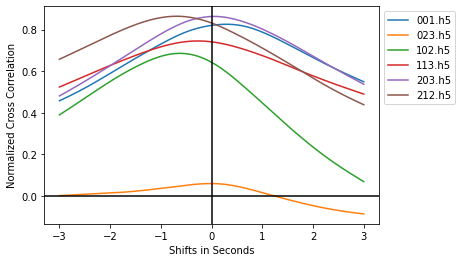

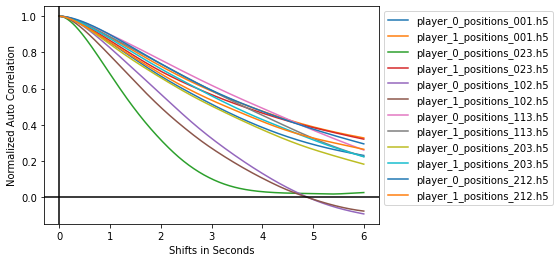

In [30]:
plot_correltations_for_folder(folder='gs_02-09-21_18-56-37',
                              title='')
# shift to left means p0 follows p1

# watched:
# 001 both competition and cooperation, seems like more cooperation in the end
# 023 mostly competition
# 102 played both, a lot of cooperation
# 203 played really cooperative, farmed also grey targets for optimality
# 

# normalized cross correlation got stronger with laps

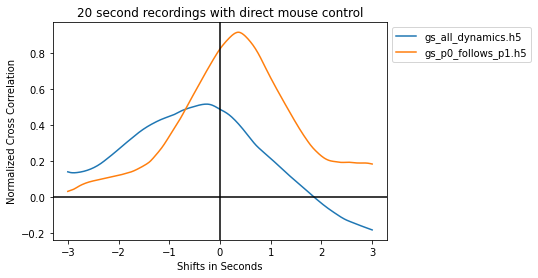

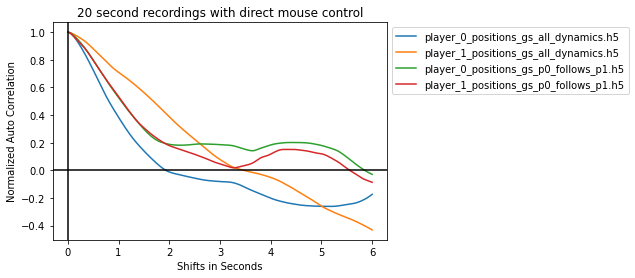

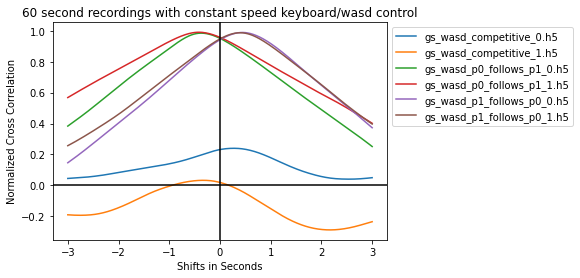

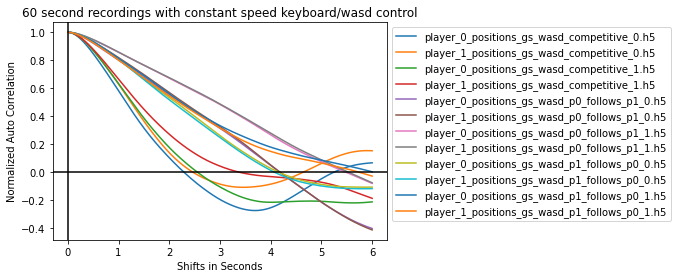

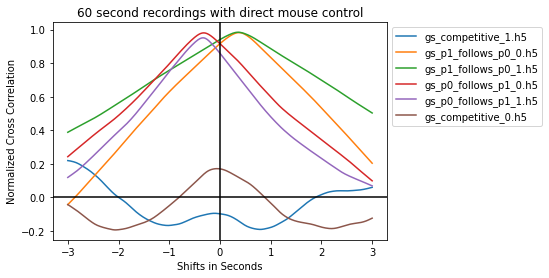

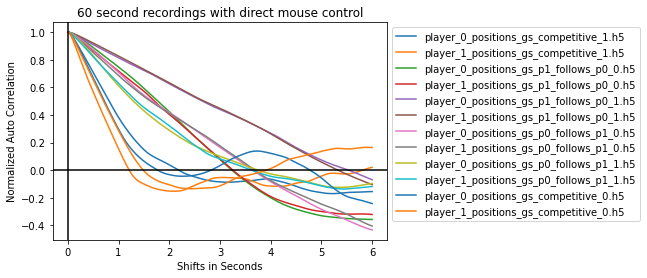

In [31]:
plot_correltations_for_folder(folder='records_0',
                              title='20 second recordings with direct mouse control')
plot_correltations_for_folder(folder='records_1',
                              title='60 second recordings with constant speed keyboard/wasd control')
plot_correltations_for_folder(folder='records_2',
                              title='60 second recordings with direct mouse control')

In [37]:
def scored(i, score_states):
    return np.isnan(score_states[i-1]) and not np.isnan(score_states[i])

def get_scorings(game_record):
    p0_ss=game_record['player_0_score_state']
    p1_ss=game_record['player_1_score_state']
    p0_ts=game_record['player_0_target_states']
    p1_ts=game_record['player_1_target_states']
    comp_p0, comp_p1, coop_p0, coop_p1 = [], [], [], []
    for i in range(1,len(p0_ss)):
        if scored(i,p0_ss) and scored(i,p1_ss) and int(p0_ts[i]) == int(p1_ts[i]):
            if p0_ss[i] > p1_ss[i]:
                coop_p0.append(i)
            else:
                coop_p1.append(i)
        else:
            if scored(i,p0_ss):
                comp_p0.append(i)
            if scored(i,p1_ss):
                comp_p1.append(i)
    return comp_p0, comp_p1, coop_p0, coop_p1

In [226]:
def frame_diffs_between_targets(targets, other_targets):
    targets = sorted(targets)
    other_targets = sorted(other_targets)
    last_target = -1
    frame_diffs = []  # first target has no predecessor
    while targets and other_targets:
        if targets[0] < other_targets[0]:
            if last_target != -1:
                frame_diffs.append(targets[0]-last_target)
            else:
                frame_diffs.append(None)
            last_target = targets.pop(0)
        else:
            last_target = -1
            _ = other_targets.pop(0)
    while targets:
        if last_target != -1:
            frame_diffs.append(targets[0]-last_target)
        else:
            frame_diffs.append(None)
        last_target = targets.pop(0)
    return frame_diffs

def avg_sec_between_targets(targets, other_targets):
    frame_diffs = frame_diffs_between_targets(targets, other_targets)
    frame_diffs = list(filter(None, frame_diffs))
    avg_frame_diffs = sum(frame_diffs)/len(frame_diffs)
    return avg_frame_diffs/conf.pos_updates_ps
        
comp_p0, comp_p1, coop_p0, coop_p1 = get_scorings(game_data)
avg_time_between_comp_p0 = avg_sec_between_targets(comp_p0, coop_p0 + coop_p1)
avg_time_between_comp_p1 = avg_sec_between_targets(comp_p1, coop_p0 + coop_p1)
avg_time_between_coop = avg_sec_between_targets(coop_p0 + coop_p1, comp_p0 + comp_p1)
print(avg_time_between_comp_p1)
print(avg_time_between_comp_p0)
print(avg_time_between_coop)
    
    

2.5366666666666666
2.9583333333333335
3.4534313725490198


In [262]:
def get_player_idx_of_tournament(recordings):
    players = []
    for record in recordings:
        if record['p0_idx'] not in players:
            players.append(record['p0_idx'])
        if record['p1_idx'] not in players:
            players.append(record['p1_idx'])
    return players

def get_player_amount(recordings):
    return 1 + max(get_player_idx_of_tournament(recordings))

def get_lap_amount(recordings):  
    highest_lap = float('-inf')
    for record in recordings:
        if record['lap'] > highest_lap:
            highest_lap = record['lap']
    return highest_lap + 1 # + 1 because lap numeration starts with 0a

def get_lap_frame_amount(recordings):
    return len(recordings[0]['timestamps'])


def flatten_accross_laps(p_occ_lap, record):
    lap_amount = get_lap_amount(record)
    lap_frame_amount = get_lap_frame_amount(record)
    return [t_occ + lap * lap_frame_amount for lap in range(lap_amount) for t_occ in p_occ_lap[lap]]
    

def player_occupations(recordings):
    player_amount = get_player_amount(recordings)
    lap_amount = get_lap_amount(recordings)
    comp_occs = [[None for i in range(lap_amount)] for k in range(player_amount)]
    sb_coop_occs = [[None for i in range(lap_amount)] for k in range(player_amount)]
    kind_coop_occs = [[None for i in range(lap_amount)] for k in range(player_amount)]
    for record in recordings:
        comp_p0, comp_p1, coop_p0, coop_p1 = get_scorings(record)
        comp_occs[record['p0_idx']][record['lap']] = comp_p0
        comp_occs[record['p1_idx']][record['lap']] = comp_p1
        sb_coop_occs[record['p0_idx']][record['lap']] = coop_p0
        sb_coop_occs[record['p1_idx']][record['lap']] = coop_p1
        kind_coop_occs[record['p0_idx']][record['lap']] = coop_p1
        kind_coop_occs[record['p1_idx']][record['lap']] = coop_p0
    occupation_dicts = []
    for p in range(player_amount):
        #player_occ_dict = {'comp':   flatten_accross_laps(comp_occs[p], recordings),
        #                   'coop_sb':flatten_accross_laps(sb_coop_occs[p], recordings),
        #                   'coop_ki':flatten_accross_laps(kind_coop_occs[p], recordings)}
        coop_sb = flatten_accross_laps(sb_coop_occs[p], recordings)
        coop_ki = flatten_accross_laps(kind_coop_occs[p], recordings)
        coop = sorted(coop_sb + coop_ki)
        self_beneficial_coop_idx = []
        kind_coop_idx = []
        for i in range(len(coop)):
            if coop[i] in coop_sb:
                self_beneficial_coop_idx.append(i)
            else:
                kind_coop_idx.append(i)
        player_occ_dict = {'comp': flatten_accross_laps(comp_occs[p], recordings),
                           'coop': coop,
                           'coop_sb': coop_sb,
                           'coop_ki': coop_ki,
                           'kind_coop_idx': kind_coop_idx,
                           'self_beneficial_coop_idx': self_beneficial_coop_idx}
        occupation_dicts.append(player_occ_dict)
    return occupation_dicts

recordings = get_game_data_dicts_for_folder('gs_02-09-21_18-56-37')
print(player_occupations(recordings)[0])


{'comp': [679, 833, 1282, 1332, 3990, 4596, 4688, 4797, 4883, 5008, 5780, 7156, 7282, 7472, 7580, 8729, 8843, 9931, 10364, 10553, 11886, 11972, 12527, 12988, 18295, 20441, 21383, 21795, 21921, 22067, 22249, 22593, 22846, 22936, 23061, 23186, 24318, 25338, 25712, 26123, 26783, 26954, 27008, 27321, 27689, 28020, 28128, 28369, 28439, 28516, 28628, 28713, 28888, 29042, 29160, 29472, 29574, 29912, 30744, 32031, 32285, 32432, 32516, 32801, 33035, 33356, 33837, 33941, 34046, 34450, 34541, 34714, 34873, 35459, 35557, 35698, 35782, 35855, 36653, 37049, 37129, 37475, 38535, 39521, 40298, 40425, 41212, 41472, 42403, 43076, 44253, 44710, 47793, 48036, 48484, 51297, 51668, 52150, 52465, 53879], 'coop': [31, 1529, 1690, 1975, 2344, 2599, 2861, 3023, 3446, 3613, 3859, 4312, 4513, 5316, 6094, 6463, 6748, 7020, 7683, 8005, 8539, 8655, 8948, 9157, 9550, 9818, 10490, 10715, 10946, 11218, 11399, 11795, 12148, 12329, 12459, 12863, 13251, 13389, 13557, 13965, 14190, 14508, 14663, 14910, 15091, 15312, 15496,

In [228]:
def get_occs_and_shift_durations(recordings):
    player_occs = player_occupations(recordings)
    for p in range(len(player_occs)):
        player_occs[p]['shift_dur_comp'] = frame_diffs_between_targets(
            targets=player_occs[p]['comp'],
            other_targets=player_occs[p]['coop'])
        player_occs[p]['shift_dur_coop'] = frame_diffs_between_targets(
            targets=player_occs[p]['coop'],
            other_targets=player_occs[p]['comp'])
    return player_occs

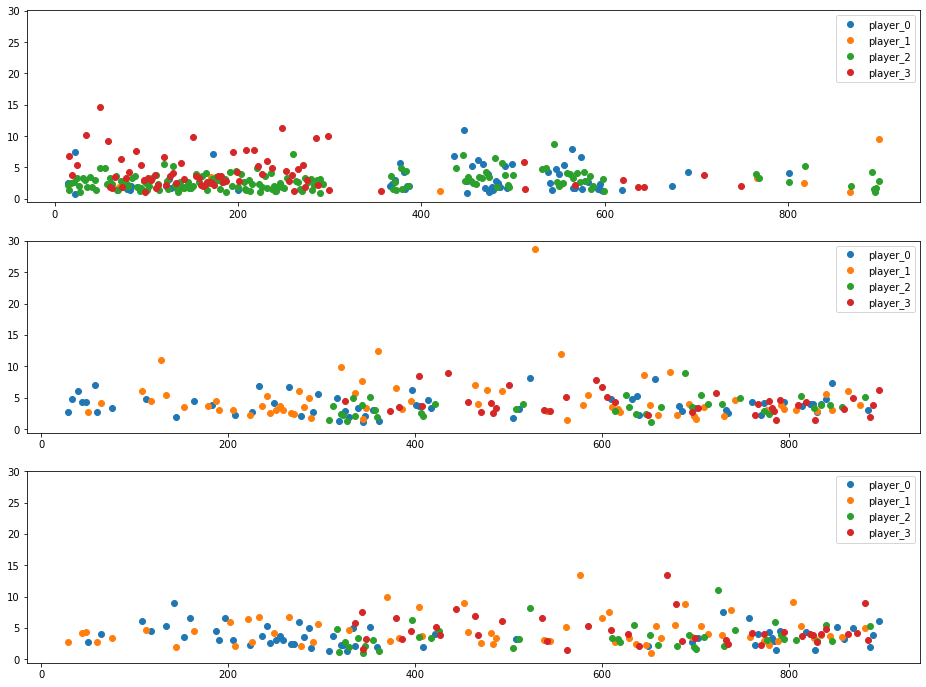

In [259]:
def get_sb_ki_only_coop_list(player_dict):
    coop_sb_only = sorted(player_dict['coop'])
    coop_ki_only = sorted(player_dict['coop'])
    for i in range(len(coop_sb_only)):
        if i not in player_dict['self_beneficial_coop_idx']:
            coop_sb_only[i] = None
        else:
            coop_ki_only[i] = None
    return coop_sb_only, coop_ki_only

def plot_coop_shift_durations(recordings):
    player_occs = get_occs_and_shift_durations(recordings)
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=((16,12)), sharey='col')
    #ax1.set_xlabel(f'Iteration ({conf.pos_updates_ps} per second)')
    #ax1.set_ylabel('Score')
    for i, player_dict in enumerate(player_occs):
        ax1.plot(frames_to_seconds(player_dict['comp']), frames_to_seconds(player_dict['shift_dur_comp']), 'o',label=f'player_{i}')
        coop_sb_only, coop_ki_only = get_sb_ki_only_coop_list(player_dict)
        ax2.plot(frames_to_seconds(coop_sb_only), frames_to_seconds(player_dict['shift_dur_coop']), 'o',label=f'player_{i}')
        ax3.plot(frames_to_seconds(coop_ki_only), frames_to_seconds(player_dict['shift_dur_coop']), 'o',label=f'player_{i}')
        
    #ax1.plot(player_occs[3]['comp'], player_occs[3]['shift_dur_comp'], 'o',label='player 0')
    #ax1.plot(game_data['player_1_scores'], label='player 1')
    ax1.legend()
    ax2.legend()
    ax3.legend()
    
    
plot_coop_shift_durations(recordings)

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def plot_player_occ_times(recordings):
    player_occs = get_occs_and_shift_durations(recordings)
    player_amount = get_player_amount(recordings)
    fig, axis = plt.subplots(nrows=player_amount, ncols=1, figsize=((16,4*player_amount)),sharey='col')
    axis = list(axis)
    for i, player_dict in enumerate(player_occs):
        axis[i].plot(player_dict['comp'], player_dict['shift_dur_comp'],
                     color=rgb_to_hex(conf.competitive_reward_color), marker='o', linestyle='',
                     label='competitive_occupations')
        
        
    #ax1.plot(player_occs[3]['comp'], player_occs[3]['shift_dur_comp'], 'o',label='player 0')
    #ax1.plot(game_data['player_1_scores'], label='player 1')
    for ax in axis:
        ax.legend()
    
#plot_player_occ_times(recordings)

54000
54000
54000
54000
54000
54000


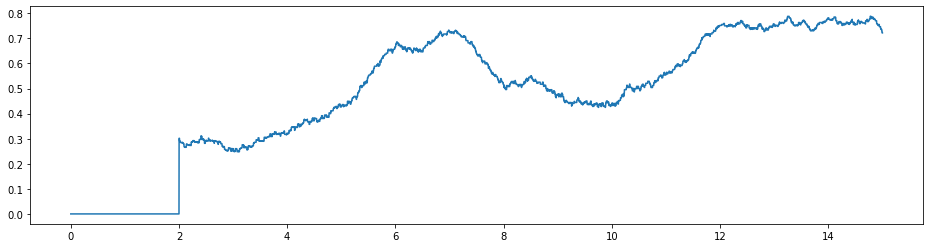

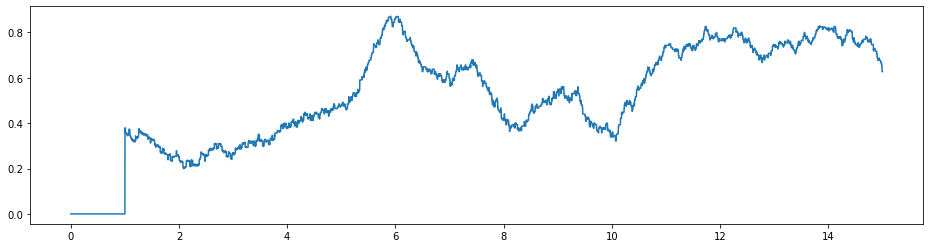

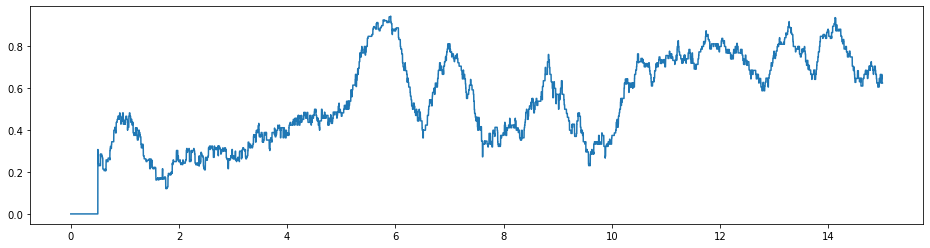

In [306]:
def get_coop_frac_window(recordings, window):
    player_occs = get_occs_and_shift_durations(recordings)
    frame_amount = get_lap_amount(recordings) * get_lap_frame_amount(recordings)
    coop_occ_timings = []
    comp_occ_timings = []
    for player_dict in player_occs:
        coop_occ_timings.extend(player_dict['coop_sb'])
        comp_occ_timings.extend(player_dict['comp'])
    #print(sorted(coop_occ_timings))
    coop_frac = [0] * window
    for i in range(window, frame_amount):
        coop_count = 0
        comp_count = 0
        for timing in coop_occ_timings:
            if i - window < timing <= i:
                coop_count += 2
        for timing in comp_occ_timings:
            if i - window < timing <= i:
                comp_count += 1
        #print(coop_count)
        coop_frac.append(coop_count/(coop_count+comp_count))
    print(len(coop_frac))
    print(frame_amount)
    return coop_frac
        
def plot_coop_frac(recordings, window):
    coop_frac = get_coop_frac_window(recordings, window)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=((16,4)), sharey='col')
    ax.plot(frames_to_mins(list(range(len(coop_frac)))),coop_frac)
    
plot_coop_frac(recordings, 60 * 120)
plot_coop_frac(recordings, 60 * 60)
plot_coop_frac(recordings, 60 * 30)

In [193]:
679 - 833

-154

In [50]:
window = 120
window = 95
window = int(avg_frames_between_coop_dots(game_data))

p0_pos = game_data['player_0_positions']
p1_pos = game_data['player_1_positions']

cross_correlation_0, cross_correlation_1 = [], []
for i in range(window, 1200):
    cross_correlation_0.append(vec_ncc(p0_pos[i-window:i], p1_pos[i-window:i], shift=best_shift_1))
    cross_correlation_1.append(vec_ncc(p0_pos[i-window:i], p1_pos[i-window:i], shift=-1*best_shift_1))

NameError: name 'best_shift_1' is not defined

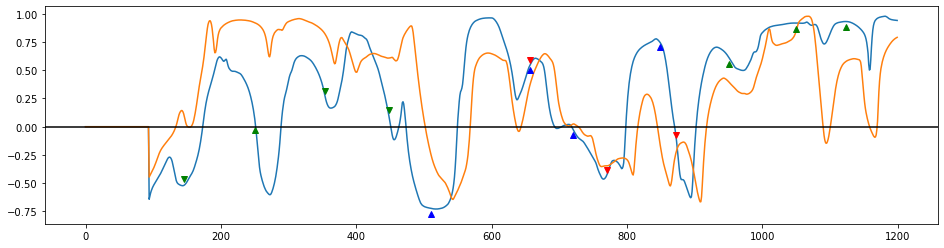

In [450]:
plt.figure(figsize=((16,4)))
plt.plot(np.array(range(window+len(cross_correlation_0))), [0]*window + cross_correlation_0)
plt.plot(np.array(range(window+len(cross_correlation_1))), [0]*window + cross_correlation_1)

def plot_event_on_curve(x_positions, curve, y_offset, fmt):
    plt.plot(x_positions, [curve[x]+y_offset for x in x_positions], fmt)

comp_p0, comp_p1, coop_p0, coop_p1 = get_scorings(game_data_all_dynamics)
plot_event_on_curve(x_positions=comp_p0, curve=[0]*window+cross_correlation_0, y_offset=.05,fmt='rv')
plot_event_on_curve(x_positions=comp_p1, curve=[0]*window+cross_correlation_0, y_offset=-.05,fmt='b^')
plot_event_on_curve(x_positions=coop_p0, curve=[0]*window+cross_correlation_0, y_offset=.05,fmt='gv')
plot_event_on_curve(x_positions=coop_p1, curve=[0]*window+cross_correlation_0, y_offset=-.05,fmt='g^')
plt.axhline(0, c='k')
plt.show()

In [ ]:
# Use best shift to classify cooperation/competition...

In [377]:
window = 180

p0_pos = game_data_all_dynamics['player_0_positions']
p1_pos = game_data_all_dynamics['player_1_positions']

best_shifts = []
from tqdm import tqdm
for i in tqdm(range(window, 1200)):
    windows_best_shift, _, _, = best_ncc_shift(p0_pos[i-window:i], p1_pos[i-window:i], search_dist=2*60)
    best_shifts.append(windows_best_shift)

100%|██████████| 1020/1020 [01:22<00:00, 12.39it/s]


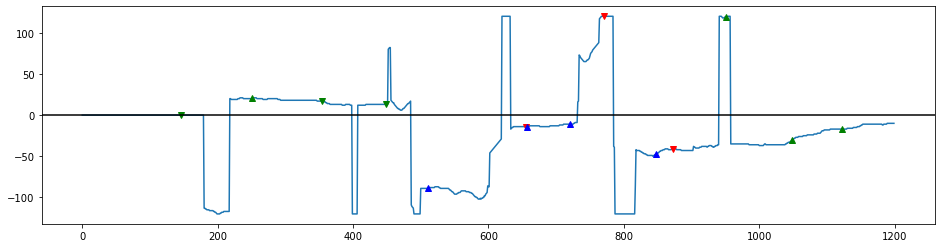

In [378]:
plt.figure(figsize=((16,4)))
plt.plot(np.array(range(window+len(best_shifts))), [0]*window+best_shifts)
plot_event_on_curve(x_positions=comp_p0, curve=[0]*window+best_shifts, y_offset=.05,fmt='rv')
plot_event_on_curve(x_positions=comp_p1, curve=[0]*window+best_shifts, y_offset=-.05,fmt='b^')
plot_event_on_curve(x_positions=coop_p0, curve=[0]*window+best_shifts, y_offset=.05,fmt='gv')
plot_event_on_curve(x_positions=coop_p1, curve=[0]*window+best_shifts, y_offset=-.05,fmt='g^')
plt.axhline(0, c='k')
plt.show()